# k-seq fitting

Data fitting parameters:
- maximum_one: if average convert percent larger than 1, change it to 1, default False
- maximum_fold: floor larger seq_count/seq_count_r5 to the value, default None


**$R^2$ Calculation**
$$
\begin{aligned}
R^2 = 1 - \frac{SS_{res}}{SS_{total}} & = 1-\frac{\sum_i (y_i - \hat{y_i})^2}{\sum_i (y_i - \bar{y_i})^2}
\end{aligned}
$$

if $R^2 < 0$, the regressor has worse prediction power than use mean (**based on dataset**) 

In [13]:
import numpy as np
from ribo import load_pickle, dump_pickle
from k_seq import data_fitting

if __name__=='__main__':
    countTable = load_pickle('/home/yuning/Work/ribozyme_pred/data/k_seq/labeled_count_table_non_empty_in_r5_INT_STD.pkl')
    print('Data table loaded, %i sequences to be fitted...' %len(countTable))    
    rndsToAvg = [[1, 2, 3, 4, 5, 6],
                 [7, 8, 10, 11, 12],
                 [13, 14, 15],
                 [19, 20, 21, 23]]
    devEstimate = True
    rndsToCount = [rnd for rndBatch in rndsToAvg for rnd in rndBatch]
    
    fittedSeqs = data_fitting(countTable[:1], rndsToAvg, devEstimate=devEstimate, eqnType=1)
    
    if devEstimate:
        dataToDump = [[seq[0], seq[1][0], seq[3], sum([1 for rnd in rndsToCount if seq[1][rnd]>0]),
                       seq[4], seq[5], seq[6], seq[7], seq[8]] for seq in fittedSeqs]
    else:
        dataToDump = [[seq[0], seq[1][0], seq[3], sum([1 for rnd in rndsToCount if seq[1][rnd]>0]),
                       seq[4], seq[5], seq[6]] for seq in fittedSeqs]
    outDirc = '/home/yuning/Work/ribozyme_pred/data/k_seq/fitted_non_empty_r5_INT_STD_exc90.csv'
    dump_pickle(dataToDump, outDirc)
    print('Fitted data has been saved to %s' %outDirc)

Data table loaded, 387764 sequences to be fitted...
[                    ] 0%

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/yuning/Work/ribozyme_pred/pkgs/k_seq.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  seq.append(1 - ss_res/ss_tot)


[====================] 98%Fitted data has been saved to /home/yuning/Work/ribozyme_pred/data/k_seq/fitted_non_empty_r5_EXT_STD_dev.csv


# Fitting results

Analysis on experimental data

For file fitted_non_empty_r5_INT_STD.csv
- 403901 sequences in total

In [566]:
from yntools import load_pickle

if __name__=='__main__':
    seqFitted = load_pickle('/home/yuning/Work/ribozyme_pred/data/k_seq/fitted_non_empty_r5_INT_STD_excNone_raw.csv')
    print('Data imported!')

Data imported!


## k vs A

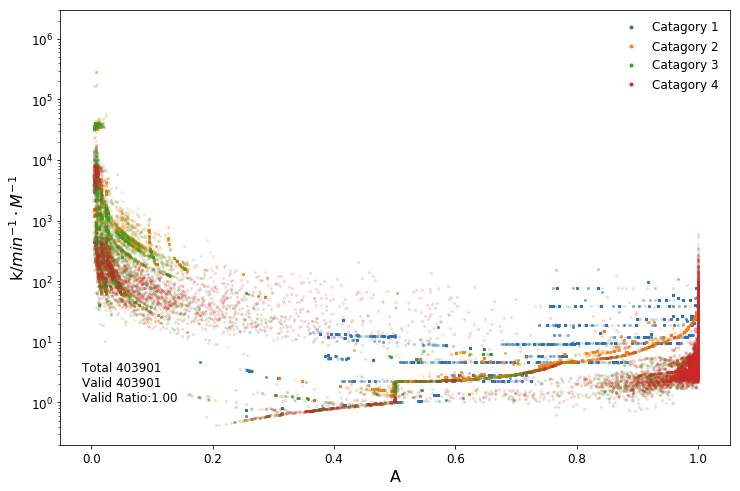

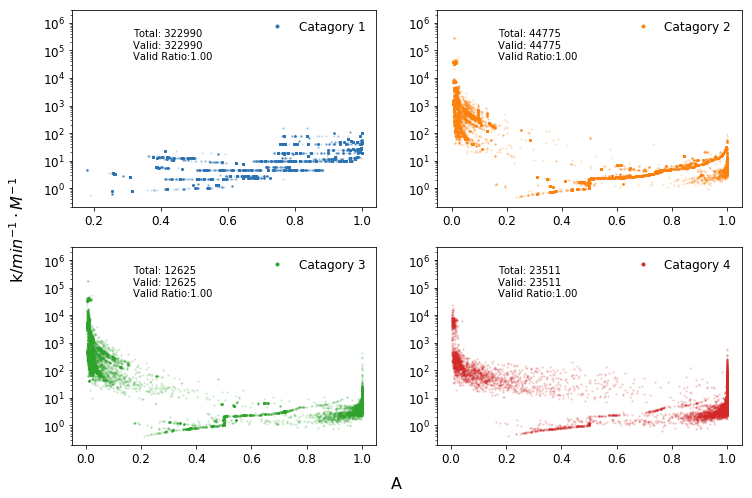

In [2]:
def data_split(samples, keyX, keyY):
    import numpy as np
    
    keyMap = {'A_avg':0, 'k_avg':1, 'kA_avg':2}
    data_X = []
    data_Y = []
    for profileNum in range(4):
        if keyX == 'r2':
            data_X.append(np.array([seq[6] for seq in samples if seq[2] == profileNum+1]))
        else:
            data_X.append(np.array([seq[4][keyMap[keyX]] for seq in samples if seq[2] == profileNum+1]))
        
        if keyY == 'r2':
            data_Y.append(np.array([seq[6] for seq in samples if seq[2] == profileNum+1]))
        else:
            data_Y.append(np.array([seq[4][keyMap[keyY]] for seq in samples if seq[2] == profileNum+1]))
    
    return data_X, data_Y
        
def plot_k_A(data_X, data_Y, xLabel, yLabel, xLog=False, yLog=False, xLim=None, yLim=None, showValidPct=False):
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines
    import numpy as np
    from plot import set_ticks_size
    
    fig = plt.figure(figsize=(12,8))
    legendHandles = []
    
    if showValidPct:
        totalSet = 0
        validSet = 0
    
    for profileNum in range(4):
        plt.scatter(data_X[profileNum], data_Y[profileNum],
                    alpha=0.15, s = 4, facecolor=colormap[profileNum])
        legendHandles.append(mlines.Line2D([],[], linestyle='None', marker='.',
                                           markeredgecolor=colormap[profileNum],
                                           markerfacecolor=colormap[profileNum],
                                           label = "Catagory %i" %(profileNum+1)))
        if showValidPct:
            validSet += sum([1 for i in range(len(data_X[profileNum])) 
                             if (np.isfinite(data_X[profileNum][i]) and np.isfinite(data_Y[profileNum][i]))])
            totalSet += len(data_X[profileNum])
        
    if xLog:
        plt.xscale('log')
    if yLog:
        plt.yscale('log')
    plt.ylabel(yLabel, fontsize = 16)
    plt.xlabel(xLabel, fontsize = 16)
    ax = plt.gca()
    if xLim:
        ax.set_xlim(xLim)
    if yLim:
        ax.set_ylim(yLim)
    
    set_ticks_size(ax)
    
    plt.legend(fontsize=12, handles=legendHandles, frameon=False)
    
    if showValidPct:
        fig.text(0.15, 0.2, 'Total %i\nValid %i\nValid Ratio:%.2f' %(totalSet, validSet, validSet/totalSet), fontsize = 12)
    
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/%s_%s_total.jpeg' %(yLabel[:1], xLabel[:1]), dpi=300)
    plt.show()

    
def plot_k_A_split(data_X, data_Y, xLabel, yLabel, xLog=False, yLog=False, xLim=None, yLim=None, showValidPct=False):
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines
    import numpy as np
    
    fig, axes = plt.subplots(2, 2, figsize=(12,8))
    
    for profileNum in range(4):
        ax = axes[round((profileNum-0.1)/2), profileNum%2]
        ax.scatter(data_X[profileNum], data_Y[profileNum], alpha=0.15, s = 2, facecolor=colormap[profileNum])
        if xLog:
            ax.set_xscale('log')
        if yLog:
            ax.set_yscale('log')
        if xLim:
            ax.set_xlim(xLim)
        if yLim:
            ax.set_ylim(yLim)
        ax.legend(handles=[mlines.Line2D([],[], linestyle='None', marker='.',
                                           markeredgecolor=colormap[profileNum],
                                           markerfacecolor=colormap[profileNum],
                                           label = "Catagory %i" %(profileNum+1))], frameon=False, fontsize=12)
        
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        
        if showValidPct:
            validSet = sum([1 for i in range(len(data_X[profileNum])) 
                            if (np.isfinite(data_X[profileNum][i]) and np.isfinite(data_Y[profileNum][i]))])
            totalSet = len(data_X[profileNum])
            pos = ax.get_position()
            fig.text(pos.x0 + 0.2*(pos.x1-pos.x0), pos.y0 + 0.75*(pos.y1-pos.y0), 
                    'Total: %i\nValid: %i\nValid Ratio:%.2f' %(totalSet, validSet, validSet/totalSet),
                    fontsize = 10, ha='left')

    fig.text(0.05, 0.5, yLabel, va='center', rotation='vertical', fontsize = 16)
    fig.text(0.5, 0.05, xLabel, ha='center', fontsize = 16)
    
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/%s_%s_sep.jpeg' %(yLabel[:1], xLabel[:1]), dpi=300)

    plt.show()
    
if __name__=='__main__':
    dataX, dataY = data_split(seqFitted, keyX='A_avg', keyY='k_avg')
    colormap = ['#2C73B4', '#FC820D', '#2EA32C', '#D32728']
    plot_k_A(dataX, dataY, xLabel='A', yLabel=r'k/$min^{-1}\cdot M^{-1}$', yLim=[0.2, 3*10**6], yLog=True, showValidPct=True)
    plot_k_A_split(dataX, dataY, xLabel='A', yLabel=r'k/$min^{-1}\cdot M^{-1}$', yLim=[0.2, 3*10**6], yLog=True, showValidPct=True)

## Fitting quality assess based on $R^2$

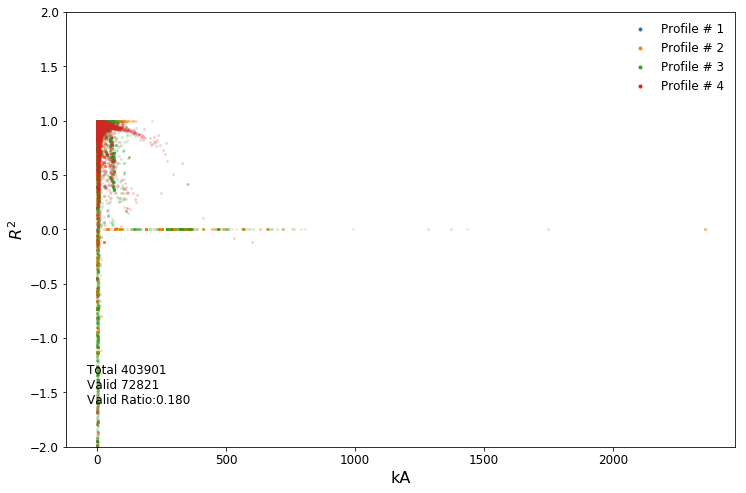

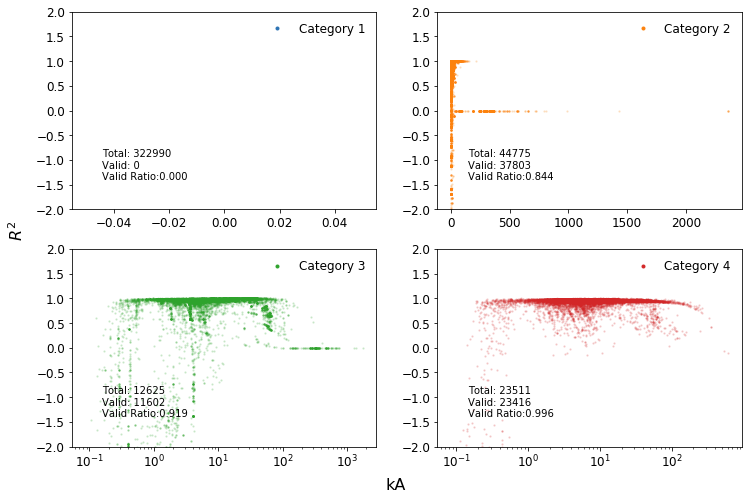

In [568]:
def data_split(samples, keyX, keyY):
    import numpy as np
    
    keyMap = {'A_avg':0, 'k_avg':1, 'kA_avg':2}
    data_X = []
    data_Y = []
    for profileNum in range(4):
        if keyX == 'r2':
            data_X.append(np.array([seq[6] for seq in samples if seq[2] == profileNum+1]))
        else:
            data_X.append(np.array([seq[4][keyMap[keyX]] for seq in samples if seq[2] == profileNum+1]))
        
        if keyY == 'r2':
            data_Y.append(np.array([seq[6] for seq in samples if seq[2] == profileNum+1]))
        else:
            data_Y.append(np.array([seq[4][keyMap[keyY]] for seq in samples if seq[2] == profileNum+1]))
    
    return data_X, data_Y
        


def plot_k_r(data_X, data_Y, xLabel, yLabel, xLog=False, yLog=False, xLim=None, yLim=None, showValidPct=False):
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines
    import numpy as np
    from plot import set_ticks_size
    
    fig = plt.figure(figsize=(12,8))
    legendHandles = []
    
    if showValidPct:
        totalSet = 0
        validSet = 0
    
    for profileNum in range(4):
        plt.scatter(data_X[profileNum], data_Y[profileNum],
                    alpha=0.15, s = 4, facecolor=colormap[profileNum])
        legendHandles.append(mlines.Line2D([],[], linestyle='None', marker='.',
                                           markeredgecolor=colormap[profileNum],
                                           markerfacecolor=colormap[profileNum],
                                           label = "Profile # %i" %(profileNum+1)))
        if showValidPct:
            validSet += sum([1 for i in range(len(data_X[profileNum])) 
                             if data_Y[profileNum][i] > 0])
            totalSet += len(data_X[profileNum])
        
    if xLog:
        plt.xscale('log')
    if yLog:
        plt.yscale('log')
    plt.ylabel(yLabel, fontsize = 16)
    plt.xlabel(xLabel, fontsize = 16)
    ax = plt.gca()
    set_ticks_size(ax)
    
    if xLim:
        ax.set_xlim(xLim)
    if yLim:
        ax.set_ylim(yLim)
    plt.legend(fontsize=12, handles=legendHandles, frameon=False)
    if showValidPct:
        fig.text(0.15, 0.2, 'Total %i\nValid %i\nValid Ratio:%.3f' %(totalSet, validSet, validSet/totalSet), fontsize = 12)
    plt.show()

    
def plot_k_r_split(data_X, data_Y, xLabel, yLabel, xLog=[False,False,False,False], yLog=[False,False,False,False], xLim=None, yLim=None, showValidPct=False):
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines
    import numpy as np
    
    fig, axes = plt.subplots(2, 2, figsize=(12,8))
    
    for profileNum in range(4):
        ax = axes[round((profileNum-0.1)/2), profileNum%2]
        ax.scatter(data_X[profileNum], data_Y[profileNum], alpha=0.15, s = 2, facecolor=colormap[profileNum])
        if xLog[profileNum]:
            ax.set_xscale('log')
        if yLog[profileNum]:
            ax.set_yscale('log')
        if xLim:
            ax.set_xlim(xLim)
        if yLim:
            ax.set_ylim(yLim)
        ax.legend(handles=[mlines.Line2D([],[], linestyle='None', marker='.',
                                           markeredgecolor=colormap[profileNum],
                                           markerfacecolor=colormap[profileNum],
                                           label = "Category %i" %(profileNum+1))], frameon=False, fontsize=12)
        
        
        if showValidPct:
            validSet = sum([1 for i in range(len(data_X[profileNum])) 
                            if data_Y[profileNum][i] > 0])
            totalSet = len(data_X[profileNum])
            pos = ax.get_position()
            fig.text(pos.x0 + 0.1*(pos.x1-pos.x0), pos.y0 + 0.15*(pos.y1-pos.y0), 
                    'Total: %i\nValid: %i\nValid Ratio:%.3f' %(totalSet, validSet, validSet/totalSet),
                    fontsize = 10, ha='left')
            
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)

    fig.text(0.05, 0.5, yLabel, va='center', rotation='vertical', fontsize = 16)
    fig.text(0.5, 0.05, xLabel, ha='center', fontsize = 16)
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/kA_r2_sep.jpeg', dpi=300, transparent=True)
    plt.show()


if __name__=='__main__':
    dataX, dataY = data_split(seqFitted, keyX='kA_avg', keyY='r2')
    colormap = ['#2C73B4', '#FC820D', '#2EA32C', '#D32728']
    plot_k_r(dataX, dataY, xLabel='kA', xLog=False, 
             yLabel=r'$R^2$', yLim=[-2, 2], showValidPct=True)
    plot_k_r_split(dataX, dataY, xLabel='kA', xLog=[False, False, True, True], 
                   yLabel=r'$R^2$', yLim=[-2, 2], showValidPct=True)

## Estimated kA distribution of real data (Mean of kA)

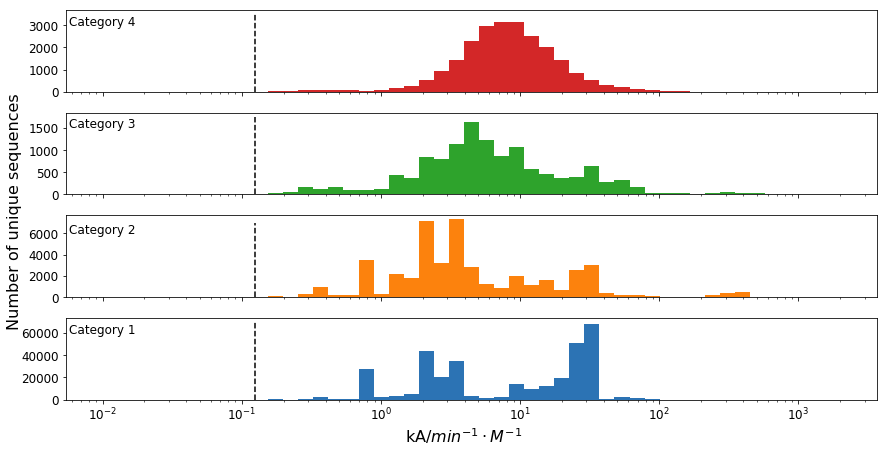

In [584]:
import matplotlib.pyplot as plt
import numpy as np
from plot import set_ticks_size

kAList = [(seq[0], seq[1], seq[2], seq[4][2], seq[8][2]) for seq in seqFitted]
colormap = ['#2C73B4', '#FC820D', '#2EA32C', '#D32728']

fig, ax = plt.subplots(4,1,figsize=[12,6], sharex=True)
plt.tight_layout()
bins = [0] + np.logspace(np.log10(0.01), np.log10(2*10**3), 50)
ylimMax = [3500, 1750, 7000, 70000]

for cat in [3,2,1,0]:
    sample = [seq[3] for seq in kAList if seq[2]==cat+1]
    ax[3-cat].hist(sample, bins=bins, color=colormap[cat])
    ax[3-cat].set_xscale('log')
    ax[3-cat].plot([0.124, 0.124],[0, ylimMax[3-cat]], 'k--')
    set_ticks_size(ax[3-cat], 12)
    ax[3-cat].text(x=0.01, y=ylimMax[3-cat]*0.9, s="Category %i" %(cat+1), fontsize=12, va='center', ha='center')

fig.text(s=r'kA/$min^{-1}\cdot M^{-1}$', x=0.5, y=-0.02, fontsize=16, ha='center', va='center')
fig.text(s='Number of unique sequences', x=-0.02, y=0.5, fontsize=16, ha='center', va='center', rotation='vertical')

fig.savefig('/home/yuning/Work/ribozyme_pred/fig/kA_dist.jpeg', dpi=300, bbox_inches='tight')
plt.show()


### Estimated kA distribution (Mean - 2 std)

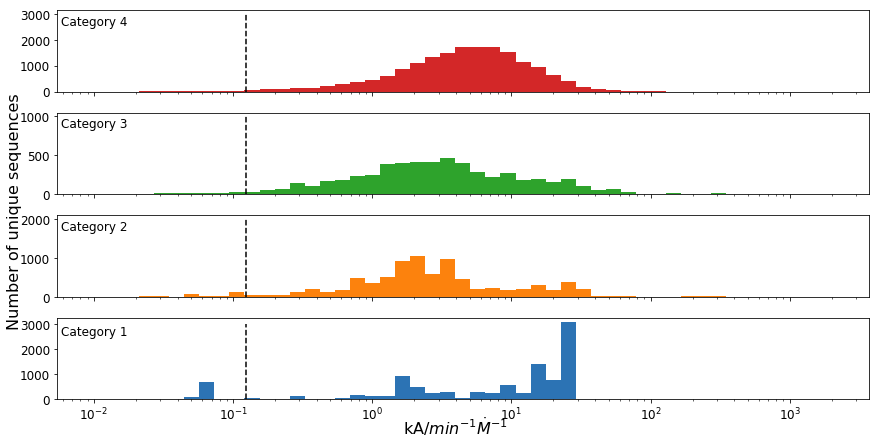

In [610]:
import matplotlib.pyplot as plt
import numpy as np

kAList = [(seq[0], seq[1], seq[2], seq[4][2], seq[8][2]) for seq in seqFitted if ~np.isnan(seq[8][2])]
colormap = ['#2C73B4', '#FC820D', '#2EA32C', '#D32728']

fig, ax = plt.subplots(4,1,figsize=[12,6], sharex=True)
plt.tight_layout()
bins = [0] + np.logspace(np.log10(0.01), np.log10(2*10**3), 50)
ylimMax = [3000, 1000, 2000, 3000]

for cat in [3,2,1,0]:
    sample = [seq[3]-2*seq[4] for seq in kAList if seq[2]==cat+1] # Mean - 2* std
    ax[3-cat].hist(sample, bins=bins, color=colormap[cat])
    ax[3-cat].set_xscale('log')
    ax[3-cat].plot([0.124, 0.124],[0, ylimMax[3-cat]], 'k--')
    set_ticks_size(ax[3-cat], 12)
    ax[3-cat].text(x=0.01, y=ylimMax[3-cat]*0.9, s="Category %i" %(cat+1), fontsize=12, va='center', ha='center')


fig.text(s=r'kA/$min^{-1}\dot M^{-1}$', x=0.5, y=0.001, fontsize=16, ha='center', va='center')
fig.text(s='Number of unique sequences', x=-0.01, y=0.5, fontsize=16, ha='center', va='center', rotation='vertical')

fig.savefig('/home/yuning/Work/ribozyme_pred/fig/kA_dist_2.jpeg', dpi=300, bbox_inches='tight')

plt.show()


## In detail analysis for categories

### Number of ribozymes are detected in the category

In [522]:
category = 1 # look at category

kAList = [(seq[0], seq[1], seq[2], seq[4][2], seq[8][2]) for seq in seqFitted]

sample = [seq for seq in kAList if seq[2]==category]
print(len(sample))
sample = [seq for seq in kAList if seq[2]==category and ~np.isnan(seq[4])] # The standard deviation can be estimated
print(len(sample))
sample = [seq for seq in kAList if seq[2]==category and ~np.isnan(seq[4]) and seq[3]-seq[4]>1] # One standard deviation away from 1 (how to interpretae this?)
print(len(sample))

322990
13297
10798


### Abundance in round 5 vs. (mean - 1 standard deviation) for sequences in category 4 and the std can be estimated  

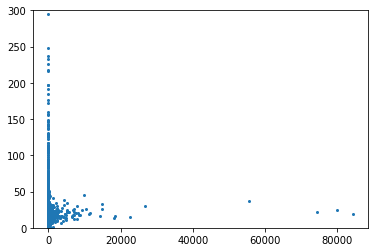

In [109]:
plt.figure()
# kAList = [(seq[0], seq[1]*10481955*0.0005, seq[2], seq[4][2], seq[8][2]) for seq in seqFitted]
plt.scatter([seq[1] for seq in kAList if seq[2]==4 and ~np.isnan(seq[4])],
            [seq[3]-seq[4] for seq in kAList if seq[2]==4 and ~np.isnan(seq[4])], s=4)
plt.ylim([0, 300])
plt.show()

### max y (fraction of ribozyme reacted) vs. kA

In [506]:
highReactiveList = [seq for seq in seqFitted if seq[2]==1 and ~np.isnan(seq[8][2])]

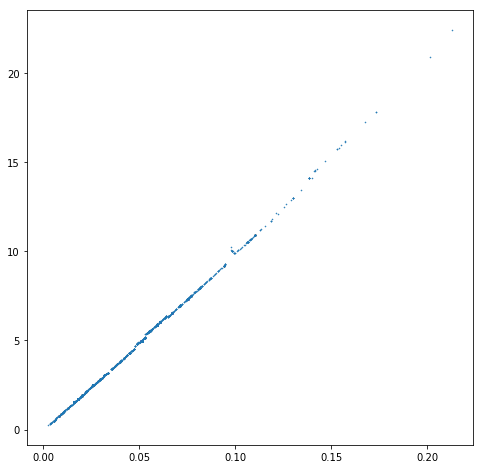

In [508]:
plt.figure(figsize=[8,8])
plt.scatter([max(seq[5]) for seq in highReactiveList], [seq[4][2] for seq in highReactiveList], s=0.3)
# plt.xlim([-0.1, 5])
plt.show()

### Fitting curve for data

TAGGCTCTTCAACAATCGGTC


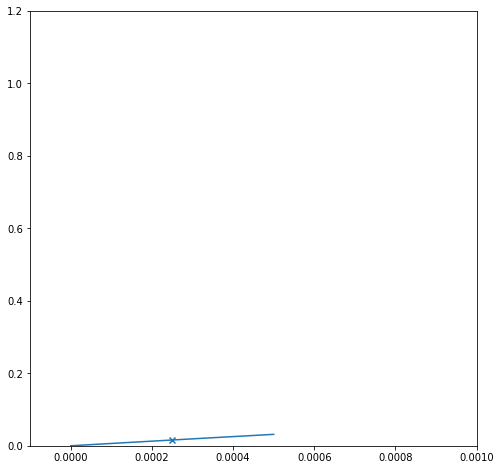

In [318]:
ix = np.random.choice([i for i in range(len(highReactiveList))])
testSeq = highReactiveList[ix]

print(testSeq[0])

plt.figure(figsize=[8,8])
plt.scatter([0.00025, 0.00005, 0.00001, 0.000002], testSeq[5], marker='x')
x = np.linspace(0, 0.0005, 1000)
y = testSeq[4][0]*(1-np.exp(-0.479*90*testSeq[4][1]*x))
plt.plot(x,y)
plt.xlim([-0.0001, 0.001])
plt.ylim([-0.0001, 1.2])
plt.show()

## Difference in using differnt fitting equation

In [530]:
from yntools import load_pickle

seqFitted = load_pickle("/home/yuning/Work/ribozyme_pred/data/k_seq/fitted_non_empty_r5_INT_STD_excNone_raw.csv")
seqSet = {seq[0]:[seq[1], seq[2], seq[3], seq[4]] for seq in seqFitted}
seqFitted = load_pickle("/home/yuning/Work/ribozyme_pred/data/k_seq/fitted_non_empty_r5_INT_STD_exc90.csv")
for seq in seqFitted:
    seqSet[seq[0]][-1].append(seq[4][2]/90)
seqFitted = load_pickle("/home/yuning/Work/ribozyme_pred/data/k_seq/fitted_non_empty_r5_INT_STD_excAll.csv")
for seq in seqFitted:
    seqSet[seq[0]][-1].append(seq[4][2]/(90*0.479))

In [534]:
stdList = [np.std(seq[3][2:])/np.mean(seq[3][2:]) for seq in seqSet.values()]

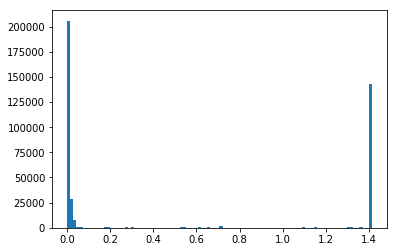

In [536]:
plt.figure()
plt.hist(stdList, bins=100)
plt.show()

# Errors in fitting algorithm
- Not errors from data
- Errors from fitting algorithm

- Two possible conditions causing error
  - All of data points are close to y=A
  - All of data points are close to y=0
  
  
## Data Y-axis coverage

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in double_scalars
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


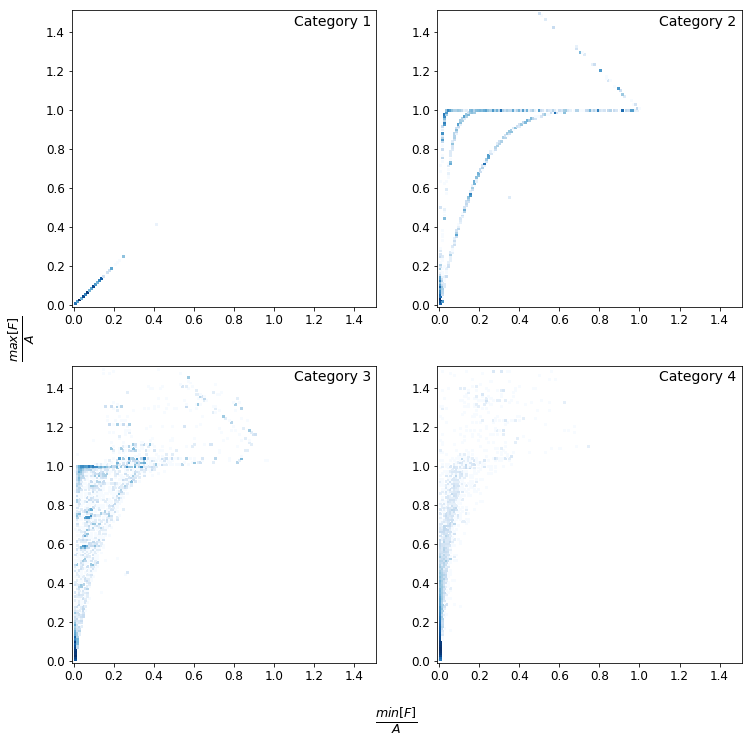

In [36]:
def plot_range_map(CountTable, minmax=False, pltType='heatmap'):
    from plot import plot_2d_heatmap
    import numpy as np
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2,2,figsize=(12,12))

    x_edges = np.linspace(-0.01, 1.5, num=150)
    y_edges = np.linspace(-0.01, 1.5, num=150)
    
    for profileNum in [0,1,2,3]:
        data = [[],[]]
        for seqs in [seq for seq in CountTable if seq[2]==profileNum+1]:
            if minmax:
                data[0].append(min(seqs[5])/seqs[4][0])
                data[1].append(max(seqs[5])/seqs[4][0])
            else:
                data[0].append(seqs[5][3]/seqs[4][0])
                data[1].append(seqs[5][0]/seqs[4][0])
        ax = axes[round((profileNum-0.1)/2), profileNum%2]
        
        if pltType=='heatmap':
            ax = plot_2d_heatmap(x=data[0], y=data[1], binx=x_edges, biny=y_edges, ax=ax, zlog=True, cmap='Blues')
        elif pltType == 'scatter':
            ax.scatter(x=data[0], y=data[1], s=3)
        
        pos = ax.get_position()
        fig.text(pos.x0 + 0.73*(pos.x1-pos.x0), pos.y0 + 0.95*(pos.y1-pos.y0), 
                    'Category %i' %(profileNum+1),
                    fontsize = 14, ha='left')
        
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        
        ax.set_xlim([-0.01, 1.51])
        ax.set_ylim([-0.01, 1.51])
    
    if minmax:
        fig.text(0.05, 0.5, r'$\frac{max{[F]}}{A}$', va='center', rotation='vertical' ,fontsize = 18)
        fig.text(0.5, 0.05, r'$\frac{min{[F]}}{A}$', ha='center', fontsize = 18)
    else:
        fig.text(0.05, 0.5, r'$\frac{[F]_{250\mu M}}{A}$', va='center', rotation='vertical' ,fontsize = 18)
        fig.text(0.5, 0.05, r'$\frac{[F]_{2\mu M}}{A}$', ha='center', fontsize = 18)
        
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/coverage.jpeg', dpi=300)
    plt.show()
   
    

if __name__=='__main__':
    seqFitted = load_pickle('/home/yuning/Work/ribozyme_pred/data/k_seq/fitted_non_empty_r5_INT_STD_excNone.csv')
    plot_range_map(seqFitted, minmax=True, pltType='heatmap')

## Fitting dev estimated from sample

1 19


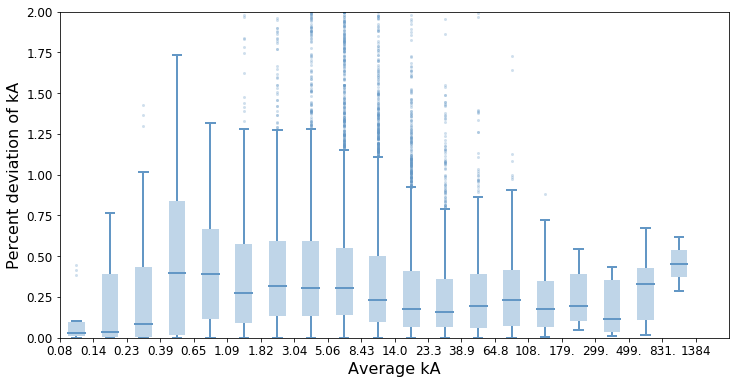

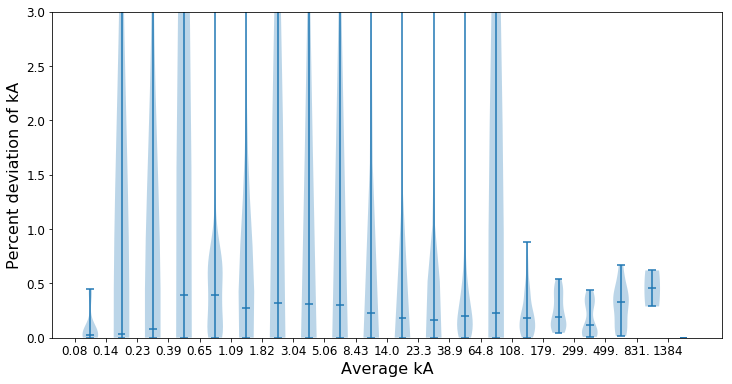

In [156]:
from yntools import load_pickle

def binning_data(k, log=False):
    import numpy as np
    
    xdata = [seq[4][k] for seq in seqFitted if (seq[7] and seq[2]>=3)]
    ydata = [seq[8][k]/seq[4][k] for seq in seqFitted if (seq[7] and seq[2]>=3)]
    if log:
        bins = np.logspace(np.log10(0.99*min(xdata)), np.log10(1.01*max(xdata)), 20)
    else:
        bins = np.linspace(0.9999*min(xdata), 1.00001*max(xdata), 20)
    binIx = np.digitize(xdata, bins)
    binned = []
    print(min(binIx), max(binIx))
    for binNum in range(20):
        binned.append([ydata[dataIx] for dataIx,ix in enumerate(binIx) if ix==(binNum+1)])
    
    return binned, bins

def plot_box():
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=[12,6])
    ax = plt.subplot()
    bplot = ax.boxplot(binned, positions=[i+0.5 for i in range(20)],
                       patch_artist=True, showfliers=True)
    ax.set_ylim([-0.001, 2.00])
    ax.set_xticks([i for i in range(20)])
    ax.set_xticklabels(['%1.4r' %i for i in bins])
    ax.set_xlabel('Average kA', fontsize=16)
    ax.set_ylabel('Percent deviation of kA', fontsize=16)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    
    for box in bplot['boxes']:
        box.set(linewidth=0)
        box.set(facecolor = '#BFD5E8')
    for whisker in bplot['whiskers']:
        whisker.set(color = '#6397C5', linewidth=2)
    for median in bplot['medians']:
        median.set(color = '#6397C5', linewidth=2)
    for cap in bplot['caps']:
        cap.set(color = '#6397C5', linewidth=2)
    for flier in bplot['fliers']:
        flier.set(markerfacecolor = '#6397C5', markersize=3, marker='o', markeredgecolor='none', alpha=0.3)
    
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/kA_err_exp_box.jpeg', dpi=300)
    plt.show()

def plot_violin():
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=[12,6])
    ax = plt.subplot()
    for i in binned:
        if len(i)==0:
            i.append(0)
    plt.violinplot(binned, positions=[i+0.5 for i in range(20)], showmedians=True)
    ax.set_ylim([-0.001, 3.00])
    # ax.set_xticks([i for i in range(20)])
    # ax.set_xticklabels(['%1.4r' %i for i in bins])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
        
    ax.set_xticks([i for i in range(20)])
    ax.set_xticklabels(['%1.4r' %i for i in bins])
    ax.set_xlabel('Average kA', fontsize=16)
    ax.set_ylabel('Percent deviation of kA', fontsize=16)
    
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/kA_err_exp_violin.jpeg', dpi=300)
    plt.show()
    
if __name__=='__main__':
    seqFitted = load_pickle('/home/yuning/Work/ribozyme_pred/data/k_seq/fitted_non_empty_r5_INT_STD_excNone_raw.csv')
    binned, bins = binning_data(2, log=True)
    plot_box()
    plot_violin()

# Simulated data

## Two possible fitfalls
1. every concentration is lower
2. every concentration is higher

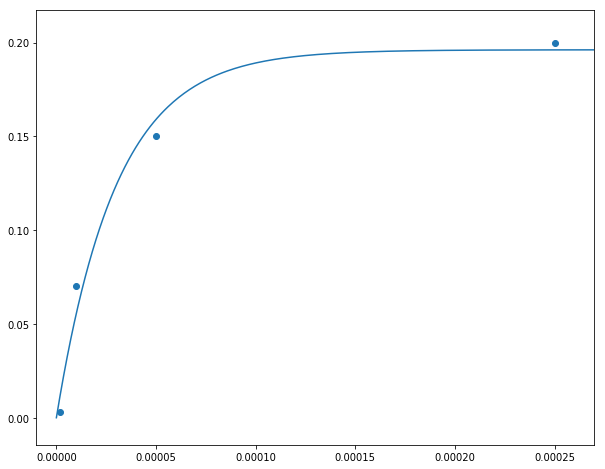

In [46]:
from scipy.optimize import curve_fit
import numpy as np

def func_0(x, A, k):
    return A * (1 - np.exp(- k * x)) # no adjustment

def plot():
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=[10,8])
    
    plt.scatter(xdata, ydata)
    x = np.linspace(0, 0.00027, 300)
    y = params[0] * (1-np.expx(-params[1] * x))
    plt.xlim([-0.00001, 0.00027])
    plt.plot(x, y)
    plt.show()


xdata = np.array([0.00025, 0.00005, 0.00001, 0.000002])
ydata = np.array([0.2, 0.15, 0.07, 0.003])

params, pcov = curve_fit(func_0, xdata=xdata, ydata=ydata,
                                         method='trf', bounds=([0, 0], [1., np.inf]))

plot()

## Influence from range of data
Set A=0.5 for fitting result compare and calculate corresponding k that make the largest concentration convertion to be 0.2A, 0.5A, 0.9A

| type | A | k |  kA|
| --| ---| --|-- |
|early 0.2A | 0.5 | 20 |
|middle 0.5A | 0.5 | 64 | 
|late 0.9A | 0.5 | 215|




| type | A | k |  kA|
| --| ---| --|-- |
|1 | 0.5 | 1 | 
|2 | 0.5 | 10 | 
|3 | 0.5 | 20|
|4 | 0.5 | 64 | 
|5 | 0.5 | 215|
|6 | 0.5 | 800 | 
|7 | 0.5 | 1600|
|8 | 0.5 | 25000 | 


Real kList always check codes
kList = [1, 10, 20, 80, 200, 800, 10000, 25000, 100000]



In [74]:
x = 0.000002
y = np.array([0.2, 0.5, 0.9])
k = np.log(1-y)/(-0.479*90*x)
k

array([ 2588.07180833,  8039.28532313, 26705.92777771])

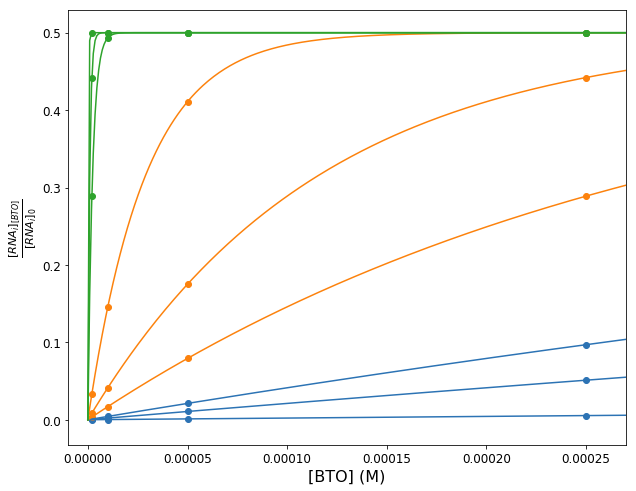

In [623]:
import matplotlib.pyplot as plt


xdata = np.array([0.00025, 0.00005, 0.00001, 0.000002])
A = 0.5
kList = [1, 10, 20, 80, 200, 800, 10000, 25000, 100000]
fig = plt.figure(figsize=[10,8])
colormap = ['#2C73B4', '#2C73B4', '#2C73B4',
            '#FC820D', '#FC820D', '#FC820D',
            '#2EA32C', '#2EA32C', '#2EA32C']

for ix,k in enumerate(kList):
    ydata = A * (1 - np.exp(-0.479 * 90 * k * xdata))
    plt.scatter(xdata, ydata, facecolors=colormap[ix])
    
    x = np.linspace(0, 0.00027, 300)
    y = A * (1 - np.exp(-0.479 * 90 * k * x))
    plt.plot(x, y, colormap[ix])
    
plt.xlim([-0.00001, 0.00027])
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
plt.ylabel(r'$\frac{[RNA_i]_{[BTO]}}{[RNA_i]_0}$', fontsize=16)
plt.xlabel('[BTO] (M)', fontsize=16)
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/simu_input.jpeg', dpi=300)
plt.show()

In [625]:
import numpy as np
import matplotlib.pyplot as plt
from yntools import progress_bar
from scipy.optimize import curve_fit
import sys

def func(x, A, k):
    return A * (1-np.exp(-0.479 * 90 * k * x))

def random_data_fitting(k):
    np.random.seed(23)
    
    xdata = np.array([0.00025, 0.00005, 0.00001, 0.000002])  # [BTO] in M
    A = 0.5
    errorPctAvg = [0.5491886, 0.3157098, 0.3277140, 0.2601247]
    errorPctStd = [0.2103583, 0.1846734, 0.1806488, 0.1814551]
    
    y = A * (1 - np.exp(-0.479 * 90 * k * xdata))
    
    fittedParamL = [[],[],[],[]]
    
    for epochs in range(300):
        errorPct = [max(0, np.random.normal(loc = errorPctAvg[i], scale = errorPctStd[i])) for i in range(4)]
        ydata = np.array([max(0, yi + np.random.normal(loc = 0, scale = errorPct[ix] * yi)) for ix,yi in enumerate(y)])
        
        try:
            popt, pcov = curve_fit(func, xdata, ydata, method='trf', bounds=([0, 0], [1., np.inf]))
        except RuntimeError:
            popt = [0,0]
        
        fittedParamL[0].append(popt[0])
        fittedParamL[1].append(popt[1])
        fittedParamL[2].append(popt[0]*popt[1])
        
        res = ydata - (1-np.exp(-0.479 * 90 * popt[1] * xdata)) * popt[0]
        ss_res = np.sum(res**2)
        ss_tot = np.sum(ydata-np.mean(ydata)**2)
        fittedParamL[3].append(1-ss_res/ss_tot)
        if epochs&10 == 0:
            progress_bar(epochs/300)
            
    return fittedParamL
if __name__=='__main__':
    fittedParamL = []
    kList = [1, 10, 20, 80, 200, 800, 10000, 25000, 100000]
    for k in kList:
        fittedParamL.append(random_data_fitting(k))

[====================] 97%

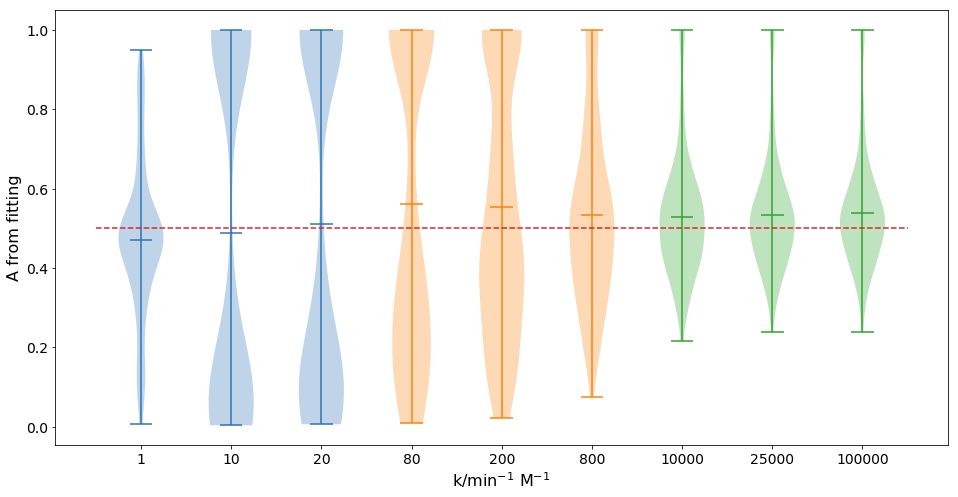

In [641]:
def violin_plot(ax, flag, dev=False):
    if flag==0:
        if dev:
            data = [(np.array(fittedParamL[i][flag]) - 0.5)/0.5 for i in range(9)]
        else:
            data = [np.array(fittedParamL[i][flag]) for i in range(9)]
    elif flag==1:
        if dev:
            data = [(np.array(fittedParamL[i][flag]) - kList[i])/kList[i] for i in range(9)]
        else:
            data = [np.array(fittedParamL[i][flag]) for i in range(9)]
    else:
        if dev:
            data = [(np.array(fittedParamL[i][flag]) - kList[i]*0.5)/(kList[i]*0.5) for i in range(9)]
        else:
            data = [np.array(fittedParamL[i][flag]) for i in range(9)]
    
    violinParts = ax.violinplot([data[i] for i in [0,1,2]],
                                 positions=[1, 2, 3], showmeans=True)
    for ix, pc in enumerate(violinParts['bodies']):
        pc.set_facecolor(colormap[0])
    violinParts['cbars'].set_edgecolor(colormap[0])
    violinParts['cmins'].set_edgecolor(colormap[0])
    violinParts['cmaxes'].set_edgecolor(colormap[0])
    violinParts['cmeans'].set_edgecolor(colormap[0])
    
    violinParts = ax.violinplot([data[i] for i in [3,4,5]],
                                 positions=[4, 5, 6], showmeans=True)
    for ix, pc in enumerate(violinParts['bodies']):
        pc.set_facecolor(colormap[3])
    violinParts['cbars'].set_edgecolor(colormap[3])
    violinParts['cmins'].set_edgecolor(colormap[3])
    violinParts['cmaxes'].set_edgecolor(colormap[3])
    violinParts['cmeans'].set_edgecolor(colormap[3])
    
    violinParts = ax.violinplot([data[i] for i in [6,7,8]],
                                 positions=[7, 8, 9], showmeans=True)
    for ix, pc in enumerate(violinParts['bodies']):
        pc.set_facecolor(colormap[6])
    violinParts['cbars'].set_edgecolor(colormap[6])
    violinParts['cmins'].set_edgecolor(colormap[6])
    violinParts['cmaxes'].set_edgecolor(colormap[6])
    violinParts['cmeans'].set_edgecolor(colormap[6])


fig = plt.figure(figsize=[16, 8])
ax = plt.gca()
violin_plot(ax, 0)
plt.plot([0.5, 9.5], [0.5, 0.5], '--')
plt.xlabel(r'k/min$^{-1}$ M$^{-1}$', fontsize=16)
plt.ylabel('A from fitting', fontsize=16)
plt.xticks([1,2,3,4,5,6,7,8,9], kList)
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/A_err_simu.jpeg', dpi=300)        
plt.show()

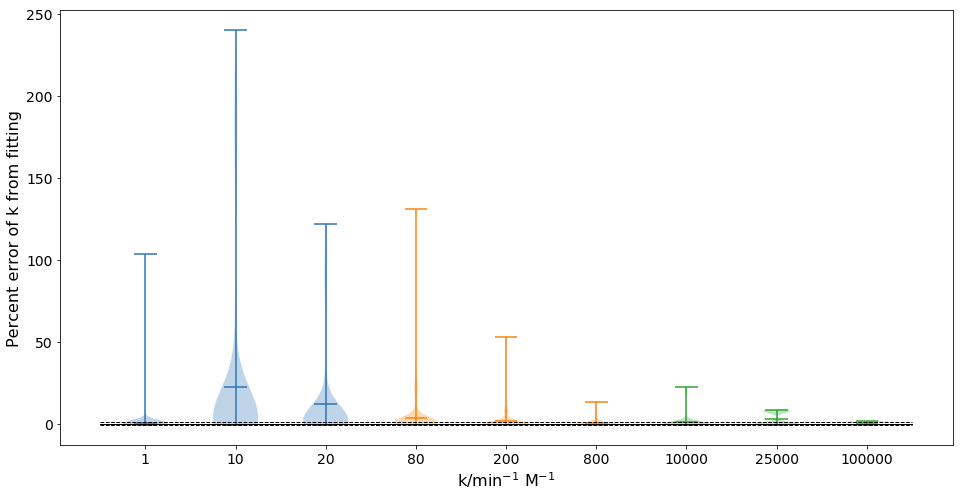

In [637]:
fig = plt.figure(figsize=[16, 8])
ax = plt.gca()
violin_plot(ax, 1,dev=True)
plt.plot([0.5, 9.5], [0.0, 0.0], 'k-', lw=1)
plt.plot([0.5, 9.5], [1, 1], 'k--', lw=1)
plt.plot([0.5, 9.5], [-1, -1], 'k--', lw=1)
plt.xlabel(r'k/min$^{-1}$ M$^{-1}$', fontsize=16)
plt.ylabel('Percent error of k from fitting', fontsize=16)
plt.xticks([1,2,3,4,5,6,7,8,9], kList)
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

    
# plt.yscale('log')  
# plt.ylim([-2,100])
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/k_pcterr_simu.jpeg', dpi=300)        

plt.show()

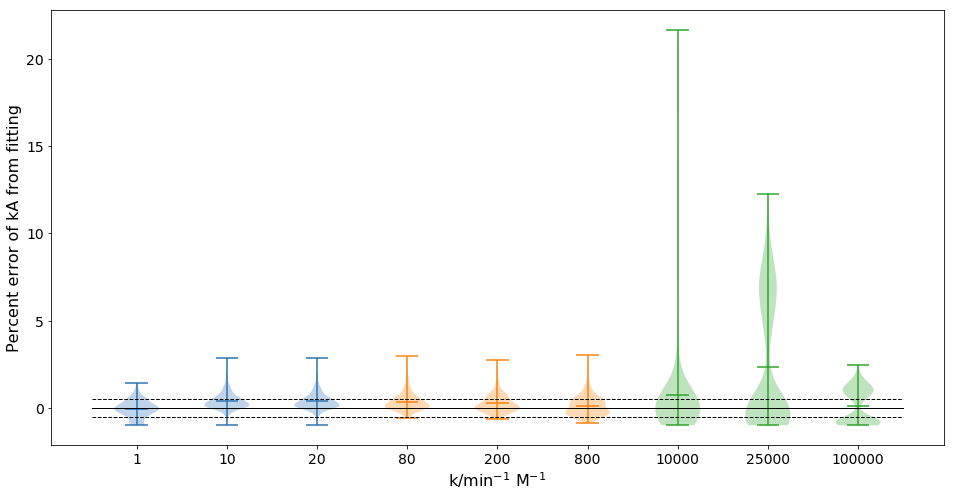

In [633]:
fig = plt.figure(figsize=[16, 8])
ax=plt.gca()
violin_plot(ax, 2,dev=True)
plt.plot([0.5, 9.5], [0.0, 0.0], 'k-', lw=1)
plt.plot([0.5, 9.5], [0.5, 0.5], 'k--', lw=1)
plt.plot([0.5, 9.5], [-0.5, -0.5], 'k--', lw=1)

plt.xlabel(r'k/min$^{-1}$ M$^{-1}$', fontsize=16)
plt.ylabel('Percent error of kA from fitting', fontsize=16)
plt.xticks([1,2,3,4,5,6,7,8,9], kList)
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

# plt.yscale('log')  
# plt.ylim([-1.1,10])
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/kA_pcterr_simu.jpeg', dpi=300)        

plt.show()

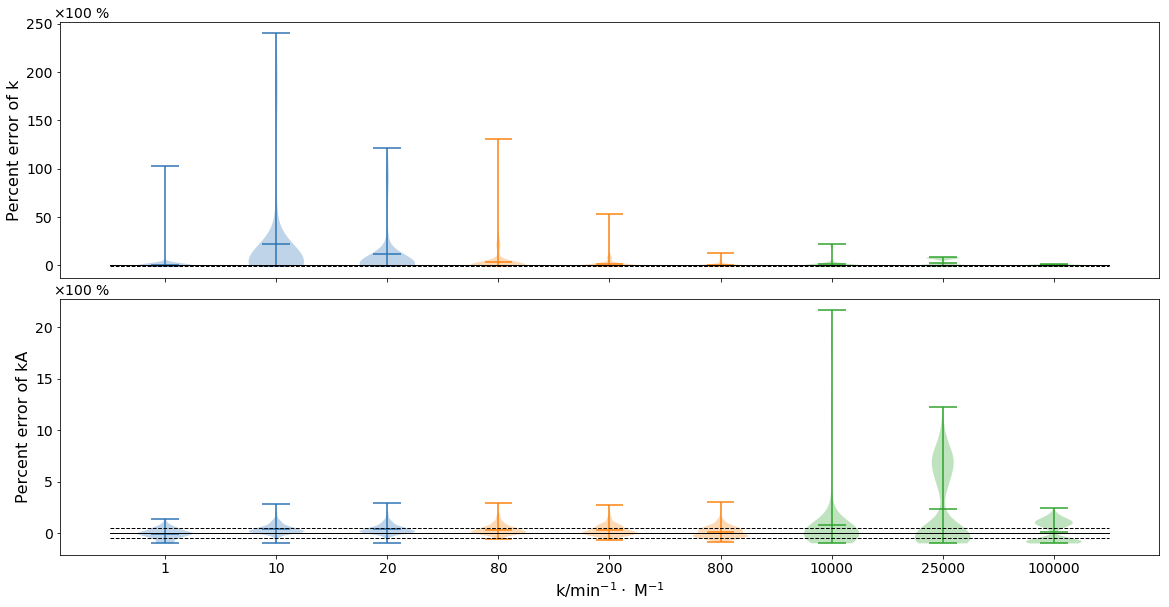

In [658]:
fig, ax = plt.subplots(2, 1, figsize=[16, 8], sharex=True)
plt.tight_layout()
violin_plot(ax[0], 1, dev=True)
ax[0].plot([0.5, 9.5], [0.0, 0.0], 'k-', lw=1)
ax[0].plot([0.5, 9.5], [0.5, 0.5], 'k--', lw=1)
ax[0].plot([0.5, 9.5], [-0.5, -0.5], 'k--', lw=1)
ax[0].set_ylabel('Percent error of k', fontsize=16)
ax[0].text(x=0.25, y=260, s=r'$\times 100\ \%$', va='center', ha='center', fontsize=14)

violin_plot(ax[1], 2, dev=True)
ax[1].plot([0.5, 9.5], [0.0, 0.0], 'k-', lw=1)
ax[1].plot([0.5, 9.5], [0.5, 0.5], 'k--', lw=1)
ax[1].plot([0.5, 9.5], [-0.5, -0.5], 'k--', lw=1)
ax[1].set_ylabel('Percent error of kA', fontsize=16)
ax[1].text(x=0.25, y=23.5, s=r'$\times 100\ \%$', va='center', ha='center', fontsize=14)

plt.xticks([1,2,3,4,5,6,7,8,9], kList)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(14)


plt.xlabel(r'k/min$^{-1}\cdot$ M$^{-1}$', fontsize=16)
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/kA_k_compare.jpeg', dpi=300, bbox_inches='tight')
plt.show()

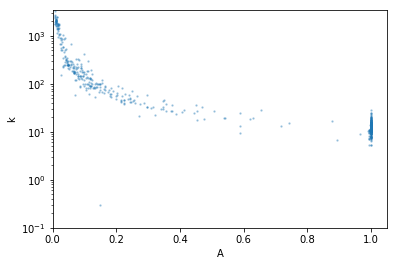

In [62]:
plt.figure()
plt.scatter(fittedParamL[0], fittedParamL[1], alpha=0.3, s=2)
plt.xlabel('A')
plt.ylabel('k')
plt.ylim(0.1,)
plt.yscale('log')
plt.xlim(0,)
plt.show()

## Influence from number of data points

choose 1,2,3,4 data points from [250, 50, 10, 2] with probability

profile 3: [0.31155115511551157, 0.2844356435643564, 0.15865346534653466, 0.24535973597359736]


profile 2: [0.3136460078168621,
 0.26049134561697374,
 0.08461194863204913,
 0.341250697934115]
 
profile 1: [0.2760487940803121,
 0.22536920647698072,
 0.05719062509675222,
 0.441391374345955]
 
### Sample probability from data

In [668]:
colormap = ['#2C73B4', '#FC820D', '#2EA32C', '#D32728']

In [660]:
import numpy as np
import matplotlib.pyplot as plt
from yntools import progress_bar
from scipy.optimize import curve_fit
import sys

def func(x, A, k):
    return A * (1-np.exp(-0.479 * 90 * k * x))

def random_data_fitting(k, categoryNum):
    np.random.seed(23)
    
    xdata = np.array([0.00025, 0.00005, 0.00001, 0.000002])  # [BTO] in M
    A = 0.5
    errorPctAvg = np.asarray([0.5491886, 0.3157098, 0.3277140, 0.2601247])
    errorPctStd = [0.2103583, 0.1846734, 0.1806488, 0.1814551]
    
    y = A * (1 - np.exp(-0.479 * 90 * k * xdata))
    
    fittedParamL = [[],[],[],[]]
    
    for epochs in range(300):
        errorPct = [max(0, np.random.normal(loc = errorPctAvg[i], scale = errorPctStd[i])) for i in range(4)]
        ydata = np.array([max(0, yi + np.random.normal(loc = 0, scale = errorPct[ix] * yi)) for ix,yi in enumerate(y)])
        valid = np.random.choice([0, 1, 2, 3], size=categoryNum, replace=False, p=weights[categoryNum-1])
        
        try:
            popt, pcov = curve_fit(func, xdata[valid], ydata[valid], method='trf', bounds=([0, 0], [1., np.inf]))
        except RuntimeError:
            popt = [0,0]
        
        fittedParamL[0].append(popt[0])
        fittedParamL[1].append(popt[1])
        fittedParamL[2].append(popt[0]*popt[1])
        
        res = ydata[valid] - (1-np.exp(-0.479 * 90 * popt[1] * xdata[valid])) * popt[0]
        ss_res = np.sum(res**2)
        ss_tot = np.sum(ydata[valid]-np.mean(ydata[valid])**2)
        fittedParamL[3].append(1-ss_res/ss_tot)
        if epochs&10 == 0:
            progress_bar(epochs/300)
            
    return fittedParamL
if __name__=='__main__':
    fittedParamL = [[], [], [], []]
    weights = [[0.2760487940803121, 0.22536920647698072, 0.05719062509675222, 0.441391374345955],
               [0.3136460078168621, 0.26049134561697374, 0.08461194863204913, 0.341250697934115],
               [0.31155115511551157, 0.2844356435643564, 0.15865346534653466, 0.24535973597359736],
               [0.25, 0.25, 0.25, 0.25]]
    
    kList = [1, 10, 20, 80, 200]
    for category in [1,2,3,4]:
        for k in kList:
            fittedParamL[category-1].append(random_data_fitting(k, category))

[=========           ] 42%

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[==                  ] 11%

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars


[====================] 97%

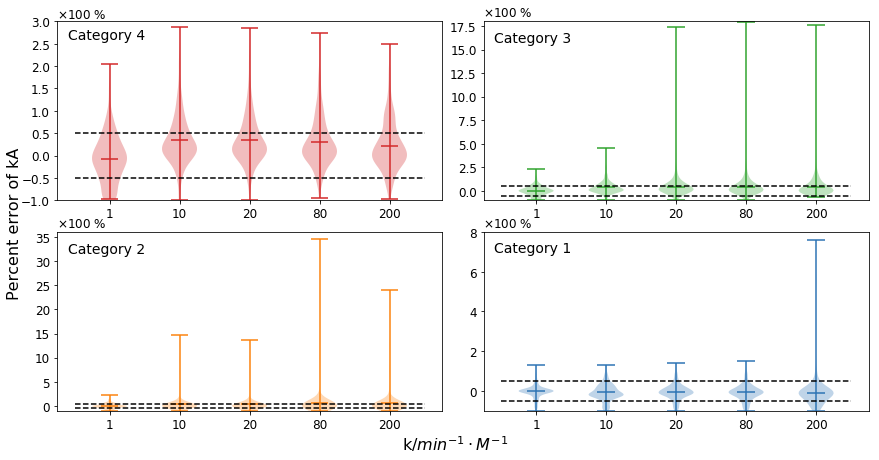

In [669]:
from plot import set_ticks_size

def violin_plot(category, ax, flag, dev=False):
    if flag==0:
        if dev:
            data = [(np.array(fittedParamL[category-1][i][flag]) - 0.5)/0.5 for i in range(5)]
        else:
            data = [np.array(fittedParamL[category-1][i][flag]) for i in range(5)]
    elif flag==1:
        if dev:
            data = [(np.array(fittedParamL[category-1][i][flag]) - kList[i])/kList[i] for i in range(5)]
        else:
            data = [np.array(fittedParamL[category-1][i][flag]) for i in range(5)]
    else:
        if dev:
            data = [(np.array(fittedParamL[category-1][i][flag]) - kList[i]*0.5)/(kList[i]*0.5) for i in range(5)]
        else:
            data = [np.array(fittedParamL[category-1][i][flag]) for i in range(5)]
    
    violinParts = ax.violinplot([data[i] for i in range(5)],
                                 positions=[1, 2, 3, 4, 5], showmeans=True)
    
    # ax[category-1].set_ylim([-3, 15])
    
    for ix, pc in enumerate(violinParts['bodies']):
        pc.set_facecolor(colormap[category-1])
    violinParts['cbars'].set_edgecolor(colormap[category-1])
    violinParts['cmins'].set_edgecolor(colormap[category-1])
    violinParts['cmaxes'].set_edgecolor(colormap[category-1])
    violinParts['cmeans'].set_edgecolor(colormap[category-1])


plt.figure()
fig,axes = plt.subplots(2,2,figsize=[12, 6])
axIx = [(0,0), (0,1), (1,0), (1,1)]
plt.tight_layout()
for ix,axix in enumerate(axIx):
    violin_plot(4-ix, axes[axix], 2, dev=True)


fig.text(x=-0.01, y=0.5, s='Percent error of kA', fontsize=16, va='center', ha='center', rotation='vertical')
fig.text(x=0.5, y=-0.01, s=r'k/$min^{-1}\cdot M^{-1}$', fontsize=16, va='center', ha='center')


ylimList = [[-1, 3], [-1, 18], [-1, 36], [-1, 8]]

for ix,axix in enumerate(axIx):
    axes[axix].set_xticks([1,2,3,4,5], kList)
    set_ticks_size(axes[axix])
    axes[axix].plot([0.5, 5.5], [0.5, 0.5], 'k--')
    axes[axix].plot([0.5, 5.5], [-0.5, -0.5], 'k--')
    axes[axix].set_ylim(ylimList[ix])
    axes[axix].set_xticklabels([0, 1, 10, 20, 80, 200])
    axes[axix].text(x=0.4, y=ylimList[ix][1]*0.9, s="Category %i" %(4-ix), va='center', ha='left', fontsize=14)
    axes[axix].text(x=0.6, y=ylimList[ix][1]*1.05, s=r'$\times 100\ \%$', va='center', ha='center', fontsize=12)


fig.savefig("/home/yuning/Work/ribozyme_pred/fig/kA_error.jpeg", dpi=300, bbox_inches='tight')        
plt.show()

In [594]:
axes[(0,1)]

In [504]:
xdata = np.array([0.00025, 0.00005, 0.00001, 0.000002])
k = 20
A = 0.5
errorPctAvg = [0.5491886, 0.3157098, 0.3277140, 0.2601247]
errorPctStd = [0.2103583, 0.1846734, 0.1806488, 0.1814551]
y = A * (1 - np.exp(-0.479 * 90 * k * xdata))
errorPct = [max(0, np.random.normal(loc = errorPctAvg[i], scale = errorPctStd[i])) for i in range(4)]
ydata = np.array([max(0, yi + np.random.normal(loc = 0, scale = errorPct[ix] * yi)) for ix,yi in enumerate(y)])
valid = np.random.choice([0, 1, 2, 3], size=1, replace=False, p=weights[1-1])

try:
    popt, pcov = curve_fit(func, xdata[valid], ydata[valid], method='trf', bounds=([0, 0], [1., np.inf]))
except RuntimeError:
    popt = [0,0]
    
print(xdata[valid])
print(ydata[valid])
print(popt[0]*popt[1])

[5.e-05]
[0.0293503]
13.883075322986826


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
